# Memory

In [ ]:
!pip install google-generativeai  # Install the correct package for Google Gemini
!pip install langchain  # Install LangChain, a popular package for LLM workflows


In [ ]:
import os
import google.generativeai as genai
from langchain_core.runnables import Runnable
from langchain.llms.base import LLM
from typing import Any, Dict

# Configure the Google Generative AI API
genai.configure(api_key="API_Keys")

# Create a generation configuration
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

# Create the Google Generative Model
model = genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  generation_config=generation_config,
)

# Custom LLM wrapper to make the Google Gemini model compatible with LangChain
class GoogleGeminiLLM(LLM):
    def _call(self, prompt: str, stop: list = None) -> str:
        # Generate a response from the Google Generative Model
        response = model.generate_content(prompt)
        return response.text

    @property
    def _identifying_params(self) -> Dict[str, Any]:
        return {"model_name": "gemini-1.5-flash"}

    @property
    def _llm_type(self) -> str:
        return "google_gemini"

# Instantiate the custom LLM wrapper
google_llm = GoogleGeminiLLM()



# Memory
  Storing messages and then extracts the messages in a variable


---


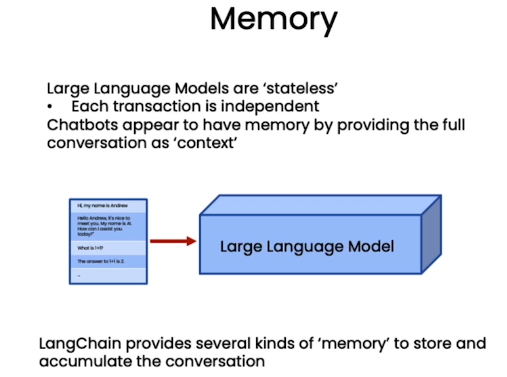

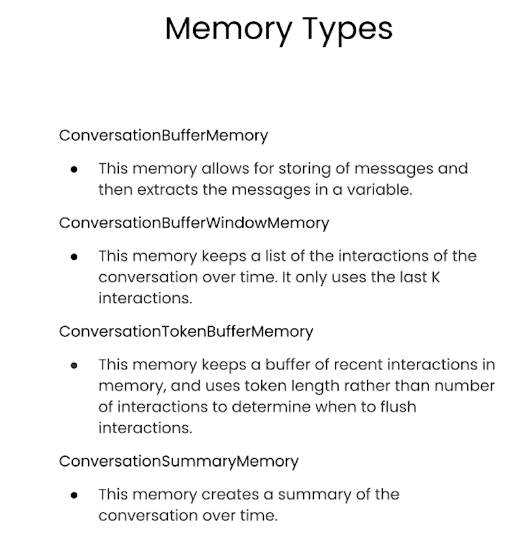

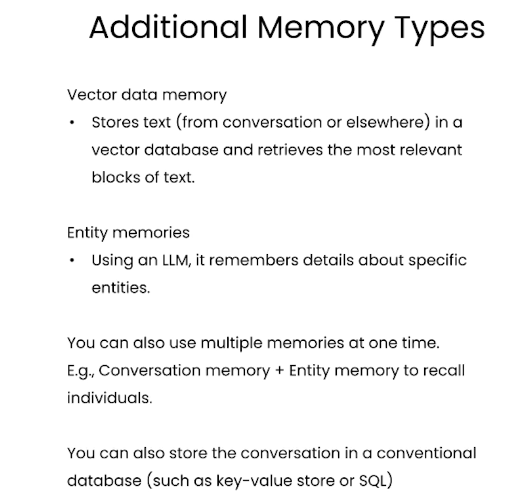

In [ ]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
# Memory for the conversation chain
memory = ConversationBufferMemory()

# Create the conversation chain with the wrapped Google LLM
conversation = ConversationChain(
    llm=google_llm,
    verbose=False, # For seeing the prompt
    memory=memory
)

# Test the conversation chain
conversation.predict(input="Hi there!")
conversation.predict(input="Hi 2")
print(memory.load_memory_variables({}))


memory2 = ConversationBufferMemory()
memory2.save_context({"input": "hi"}, {"output": "whats up"})
print(memory2.load_memory_variables({}))

{'history': "Human: Hi there!\nAI: Hi! 👋 How can I help you today? I'm ready to chat about anything you'd like, from the latest news to the history of the universe. What's on your mind? 😄 \n\nHuman: Hi 2\nAI: Hi there! 😄 It's nice to meet you.  What are you interested in learning about today?  I'm full of fun facts and ready to share!  😊 \n"}
{'history': 'Human: hi\nAI: whats up'}


In [ ]:
#  Buffer Window Memory
from langchain.memory import ConversationBufferWindowMemory
window_memory = ConversationBufferWindowMemory(k=1)  # Remember last k conversation
window_memory.save_context({"input": "hi"}, {"output": "whats up"})
window_memory.save_context({"input": "not much you"}, {"output": "not much"})
window_memory.load_memory_variables({})

{'history': 'Human: not much you\nAI: not much'}

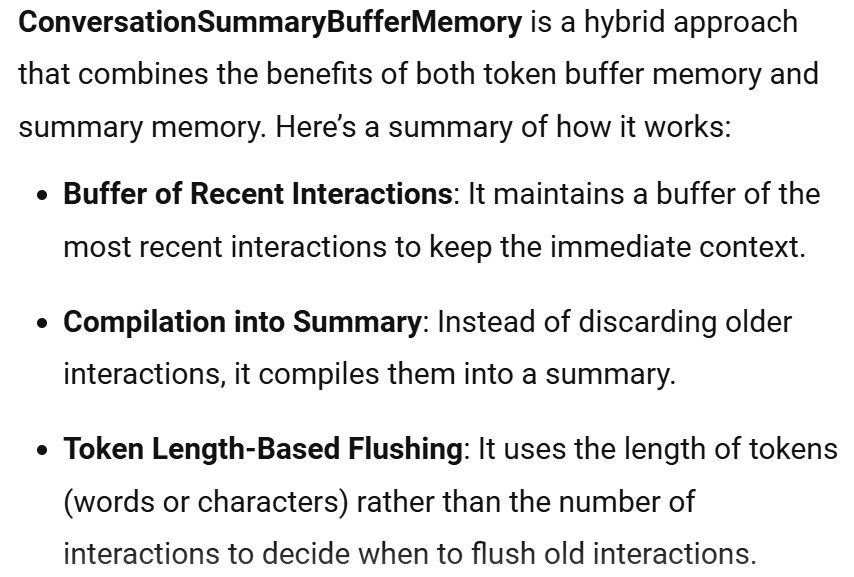

In [ ]:
# Token Buffer Memory
from langchain.memory import ConversationTokenBufferMemory
token_memory = ConversationTokenBufferMemory(llm=google_llm, max_token_limit=50) # remember max_token_limit
token_memory.save_context({"input": "hi"}, {"output": "whats up"})
token_memory.save_context({"input": "not much you"}, {"output": "not much"})
token_memory.load_memory_variables({})

{'history': 'Human: hi\nAI: whats up\nHuman: not much you\nAI: not much'}

In [ ]:
# summary Buffer memory
from langchain.memory import ConversationSummaryBufferMemory

# create a long string
schedule = "There is a meeting at 8am with your product team. \
You will need your powerpoint presentation prepared. \
9am-12pm have time to work on your LangChain \
project which will go quickly because Langchain is such a powerful tool. \
At Noon, lunch at the italian resturant with a customer who is driving \
from over an hour away to meet you to understand the latest in AI. \
Be sure to bring your laptop to show the latest LLM demo."

memory = ConversationSummaryBufferMemory(llm=google_llm, max_token_limit=100)
memory.save_context({"input": "Hello"}, {"output": "What's up"})
memory.save_context({"input": "Not much, just hanging"},
                    {"output": "Cool"})
memory.save_context({"input": "What is on the schedule today?"},
                    {"output": f"{schedule}"})
memory.load_memory_variables({})

{'history': 'System: The human greets the AI and the AI responds in kind. The human then informs the AI that they are not doing much, and the AI acknowledges. Finally, the human asks what is on the schedule for the day. \n\nAI: There is a meeting at 8am with your product team. You will need your powerpoint presentation prepared. 9am-12pm have time to work on your LangChain project which will go quickly because Langchain is such a powerful tool. At Noon, lunch at the italian resturant with a customer who is driving from over an hour away to meet you to understand the latest in AI. Be sure to bring your laptop to show the latest LLM demo.'}